<div style="background-color: lightgreen; border-radius: 5px; padding: 10px;">
    <h4>Word Embedding Categorisation</h4>
    <p>...</p>
</div>

### imports

In [1]:
from preprocessing_functions import *
from word_embedding_functions import *

import pandas as pd
import numpy as np
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

- Clean and preprocess (lemmatise) a list of documents (e.g. paragraphs)
- Get your topics through unsupervised clustering with (LDA Topic Modeling)
- Use these for the word embedding algorithm

### 1. Set Topic Words
<br>
<div style="text-align: justify;">Using LDA topic modeling to find topics and their words through unsupervised clustering highly increases the performance of the model. Look at the pyLDAvis visualisation of the LDA topic model and change any parameters if you are not happy with the cluster distributions or if any clusters are overlapping. </div>
<br>
<div style="text-align: justify;">
A good topic model will have relatively big, similarly sized and non-overlapping bubbles scattered throughout the chart. Greater distances between the clusters represents a larger semantic difference, similarly sized bubbles show that the topics are equally represented, and large circles mean that the topics are well represented in the documents. By paying attention to these three characteristics we can get an accurate representation of the dominant topics of our documents and decide whether these clusters represent good, meaningful topics.
</div>

In [92]:
# Removing words with double meaning helps (e.g. bear, degree)

#fashion_words = ['fashion', 'model', 'vogue', 'store', 'designer', 'couture', 'catwalk', 'runway', 'modeling', 'clothing', 'cosmetic', 'brand', 'retail', 'advertising', 'perfume']
diplomacy_words = ['War', 'Embassy', 'Army', 'Diplomatic', 'Ambassador', 'Treaty', 'Protest', 'Force', 'Mission', 'Arrest', 'Government', 'Police', 'Attack', 'Party', 'Minister']
entertainment_words = ['Opera', 'Festival', 'Perform', 'Orchestra', 'Symphony', 'Concert', 'Music', 'Film', 'Sing', 'Theatre', 'Performance', 'Role', 'Premiere', 'Tour', 'Band']
art_words = ['Exhibition', 'Art', 'Museum', 'Gallery', 'Exhibit', 'Painting', 'Collection', 'Paint', 'Portrait', 'Artist', 'Sculpture', 'Fashion', 'Design', 'Contemporary', 'Painter']
education_words = ['Study', 'School', 'Professor', 'University', 'Graduate', 'Educate', 'Lecture', 'Research', 'College', 'Teach', 'Science', 'Education', 'Philosophy', 'Doctorate', 'Faculty'] # replaced bear with educate and degree with Lecture
transportation_words = ['Railway', 'Route', 'Line', 'Operate', 'Flight', 'Station', 'Service', 'Airline', 'Airport', 'Train', 'Passenger', 'Speed', 'Aircraft', 'Rail', 'Network']
sport_words = ['Final', 'Win', 'Team', 'Match', 'Game', 'Goal', 'Club', 'League', 'Champion', 'Championship', 'Season', 'Score', 'Round', 'Tournament', 'Football']

lda_topic_words = { #'fashion': fashion_words,
                    'diplomacy': diplomacy_words,
                   'entertainment': entertainment_words,
                   'art': art_words,
                   'education': education_words,
                   'transportation': transportation_words,
                   'sport': sport_words}

### 2. Loading GloVe Word Embedding
<br>
<div style="text-align: justify;"> The word embedding model could be replaced by other ones fairly easy, but for now we decided to use the Common Crawl 840B token one  (source: https://nlp.stanford.edu/projects/glove/).</div>

In [3]:
%%time

embeddings_dict, discarded_dict = load_glove_word_embeddings(GLOVE_PATH="../../../../../glove.840B.300d.txt")

This will take approximately ~ 4 minutes...


  0%|          | 0/2196017 [00:00<?, ?it/s]

CPU times: total: 10min 34s
Wall time: 10min 52s


### 3. Get Mean of the words from each Topic
<br>
<div style="text-align: justify;">By taking the mean of the vectors that belong to the ~15 most relevant words of a topic we get a fairly accurate vector representation of a topic. We do this for each topic and save their vector value to a dictionary for later retrieval.</div>

In [93]:
mean_vectors_dict = {}
for topic in lda_topic_words:
    words = lda_topic_words[topic]
    words = [word for word in words if word in embeddings_dict.keys()] # checks if word is in vocabulary (i.e. has been seen by the model before)
    mean_embedding = np.mean([embeddings_dict[word.lower()] for word in words], axis=0)
    mean_vectors_dict[topic] = mean_embedding

### 4. Load Documents

In [5]:
from ast import literal_eval

# df = pd.read_csv("../../../../../data/clean/classified_435_citypairs_311k_paragraphs.csv")
# df = pd.read_csv("../../../../../data/clean/classified_50cities_740citypairs_400k_paragraphs.csv")
df =  pd.read_csv("../../../../../data/clean/lda_classified_30cities_435citypairs_311k_paragraphs.csv") 
df['merged_POS'] = df['merged_POS'].apply(literal_eval)

In [40]:
from ast import literal_eval

df2 = pd.read_csv("../../../../../data/clean/classified_435_citypairs_311k_paragraphs.csv")
df2['merged_POS'] = df2['merged_POS'].apply(literal_eval)

In [6]:
df.columns

Index(['paragraph_id', 'city_pair', 'paragraph', 'merged_POS', 'lda_sport',
       'lda_art', 'lda_diplomacy', 'lda_entertainment', 'lda_transportation',
       'lda_education', 'lda_dominant', 'lda_dominant_score'],
      dtype='object')

### Select number of paragraphs to process

In [8]:
sample = df[:]

### 5. Classify Paragraphs (by Word Embedding Algorithm)

#### 5.1 Select right parameters
<br>
<div style="text-align: justify;">bottom_threshold: If the similarity between a word and its closest topic is below the bottom_threshold it will be discarded from the classification process.
Verbose1 and Verbose2: Enabling these will print out the internal process of the algorithm.</div>

In [94]:
bottom_threshold = 0.20
verbose1 = False
verbose2 = False

In [97]:
%time
# ~40 mins for 311k paragraphs

topics = [key for key in list(sorted(mean_vectors_dict.keys()))]
nested_l = [['index']+topics+['embedding_dominant']]

for idx, row in tqdm(sample['merged_POS'].iteritems(), total=len(sample['merged_POS'])):
    output = categorize_text(lemmatized_wordlist=row, mean_vectors_dict=mean_vectors_dict, keywords=topics, embeddings_dict=embeddings_dict, bottom_threshold=bottom_threshold, verbose1=verbose1, verbose2=verbose2)
    
    temp_l = [idx] +[result[1] for result in output['category_similarities']] + [output['prediction']]
    
    #print(row, output['category_similarities'])
    
    if len(nested_l[0]) != len(temp_l):
        raise Exception('Not the same size!')
        
    nested_l.append(temp_l)


prediction_df = pd.DataFrame(nested_l[1:],columns=nested_l[0]).set_index('index')

CPU times: total: 0 ns
Wall time: 975 µs


  0%|          | 0/310828 [00:00<?, ?it/s]

In [174]:
prediction_df['embedding_dominant'].value_counts()

diplomacy         68981
entertainment     64498
education         51413
transportation    44715
art               42557
sport             38664
Name: embedding_dominant, dtype: int64

### 4. Insert classification into dataset

In [100]:
updated_df = sample.join(prediction_df)
updated_df.head(2)
updated_df['same_categorisation'] = updated_df.apply(lambda x: x.lda_dominant.endswith(x.embedding_dominant), axis=1) # (updated_df['embedding_dominant'].isin('lda_dominant') 'lda_dominant'].str.contains() == updated_df['outcome'])

#### Similarity between lda topic model and word embedding algorithm output

In [111]:
same_categorisation = updated_df[updated_df['same_categorisation'] == False]['same_categorisation'].count()
total_documents = updated_df['same_categorisation'].count()

print(f"{same_categorisation} out of {total_documents} were classified the same by the LDA topic model and word embedding classification model.")

57600

In [121]:
print(updated_df[(updated_df['lda_dominant_score'] > 0.9) & (updated_df['merged_POS'].str.len() > 5)].groupby('lda_dominant')['same_categorisation'].value_counts())
print('----------------------------------------------------')
print(updated_df[(updated_df['lda_dominant_score'] > 0.9) & (updated_df['merged_POS'].str.len() > 5)].groupby('lda_dominant')['same_categorisation'].value_counts(normalize=True))

lda_dominant        same_categorisation
lda_art             True                   19412
                    False                   3147
lda_diplomacy       True                   25950
                    False                   1157
lda_education       True                   19783
                    False                   3274
lda_entertainment   True                   32633
                    False                   1148
lda_sport           True                   21597
                    False                    248
lda_transportation  True                   25697
                    False                   2420
Name: same_categorisation, dtype: int64
----------------------------------------------------
lda_dominant        same_categorisation
lda_art             True                   0.860499
                    False                  0.139501
lda_diplomacy       True                   0.957317
                    False                  0.042683
lda_education       True       

### binned LDA scores of all & differently classified paragraphs

In [113]:
updated_df['lda_dominant_score'].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).sort_index(ascending=False)

(0.9, 1.0]       162233
(0.8, 0.9]        36067
(0.7, 0.8]        33458
(0.6, 0.7]        31646
(0.5, 0.6]        29996
(0.4, 0.5]        14427
(0.3, 0.4]         2909
(0.2, 0.3]           92
(0.1, 0.2]            0
(-0.001, 0.1]         0
Name: lda_dominant_score, dtype: int64

In [112]:
updated_df[updated_df['same_categorisation'] != True]['lda_dominant_score'].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).sort_index(ascending=False) #  .sum() # .sort_index(ascending=False) #.sort_values(ascending=False)

(0.9, 1.0]       13049
(0.8, 0.9]        5202
(0.7, 0.8]        7231
(0.6, 0.7]        9850
(0.5, 0.6]       12775
(0.4, 0.5]        7662
(0.3, 0.4]        1767
(0.2, 0.3]          64
(0.1, 0.2]           0
(-0.001, 0.1]        0
Name: lda_dominant_score, dtype: int64

In [122]:
updated_df

,paragraph_id,city_pair,paragraph,merged_POS,lda_sport,lda_art,lda_diplomacy,lda_entertainment,lda_transportation,lda_education,lda_dominant,lda_dominant_score,art,diplomacy,education,entertainment,sport,transportation,embedding_dominant,same_categorisation
0,1,berlin_milan,"after his tenure in academia, he continued to ...","[tenure, academia, month, year, travel, incide...",0.000765,0.001501,0.770121,0.001536,0.001327,0.224750,lda_diplomacy,0.770121,1.077087,9.597548,1.932452,0.000000,2.453161,2.040116,diplomacy,True
1,2,berlin_milan,one of the astronomers selected for the search...,"[astronomer, search, priest, invitation, group...",0.195772,0.498009,0.302968,0.001100,0.000950,0.001201,lda_art,0.498009,1.103501,2.904709,4.811566,1.668829,1.891043,1.988286,education,False
2,3,berlin_milan,there are plenty of air connections between ye...,"[plenty, air, connection, city, connection, ci...",0.000873,0.001713,0.002005,0.001754,0.991741,0.001914,lda_transportation,0.991741,0.000000,1.592254,0.531098,0.000000,1.199944,11.011679,transportation,True
3,4,berlin_milan,"since 2009, 'the brandery', an urban fashion s...","[fashion, year, language, monitor, ranking, wo...",0.383249,0.602904,0.003862,0.003379,0.002918,0.003687,lda_art,0.602904,2.153451,1.762085,0.942167,0.000000,1.968153,0.364845,art,True
4,5,berlin_milan,when considering the commuter belts or metropo...,"[commuter, belt, area, datum, population, orde...",0.002721,0.005337,0.094386,0.005463,0.886130,0.005962,lda_transportation,0.886130,0.000000,0.809625,0.446223,0.347665,0.000000,2.849543,transportation,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310823,312682,warsaw_valencia,"since 2010, edelmann has intensified his conce...","[concert, activity, guest, performance, recita...",0.001889,0.003704,0.004335,0.982658,0.003276,0.004139,lda_entertainment,0.982658,0.000000,0.760049,0.456211,4.984097,0.000000,0.000000,entertainment,True
310824,312683,warsaw_valencia,"born maria mokrzycka in lviv (now ukraine), sh...","[conservatory, debut, opera, opera, time, bari...",0.000729,0.001430,0.001673,0.993306,0.001264,0.001597,lda_entertainment,0.993306,1.716277,0.773917,2.472730,9.914883,1.060039,1.210814,entertainment,True
310825,312684,warsaw_valencia,ayala was elected a fellow of the american aca...,"[fellow, art, science, member, society, member...",0.001683,0.003300,0.003862,0.003379,0.002918,0.984857,lda_education,0.984857,1.750858,2.044300,6.493432,0.000000,0.000000,0.000000,education,True
310826,312685,warsaw_valencia,o'conor was a co-founder of the dublin interna...,"[co, founder, competition, director, chairman,...",0.001382,0.092213,0.003171,0.584548,0.002396,0.316290,lda_entertainment,0.584548,0.726228,2.072411,1.906426,1.054776,1.875478,0.953029,diplomacy,False


### Saving "Classified Paragraphs" Dataframe

In [123]:
updated_df.to_csv('..\..\..\..\..\data\clean\lda_classified_30cities_435citypairs_311k_paragraphs_both_methods_with_education.csv', index=False)

In [172]:
print(len(updated_df))
updated_df.head(5)

310828


,paragraph_id,city_pair,paragraph,merged_POS,lda_sport,lda_art,lda_diplomacy,lda_entertainment,lda_transportation,lda_education,lda_dominant,lda_dominant_score,art,diplomacy,education,entertainment,sport,transportation,embedding_dominant,same_categorisation
0,1,berlin_milan,"after his tenure in academia, he continued to ...","[tenure, academia, month, year, travel, incide...",0.000765,0.001501,0.770121,0.001536,0.001327,0.224750,lda_diplomacy,0.770121,1.077087,9.597548,1.932452,0.000000,2.453161,2.040116,diplomacy,True
1,2,berlin_milan,one of the astronomers selected for the search...,"[astronomer, search, priest, invitation, group...",0.195772,0.498009,0.302968,0.001100,0.000950,0.001201,lda_art,0.498009,1.103501,2.904709,4.811566,1.668829,1.891043,1.988286,education,False
2,3,berlin_milan,there are plenty of air connections between ye...,"[plenty, air, connection, city, connection, ci...",0.000873,0.001713,0.002005,0.001754,0.991741,0.001914,lda_transportation,0.991741,0.000000,1.592254,0.531098,0.000000,1.199944,11.011679,transportation,True
3,4,berlin_milan,"since 2009, 'the brandery', an urban fashion s...","[fashion, year, language, monitor, ranking, wo...",0.383249,0.602904,0.003862,0.003379,0.002918,0.003687,lda_art,0.602904,2.153451,1.762085,0.942167,0.000000,1.968153,0.364845,art,True
4,5,berlin_milan,when considering the commuter belts or metropo...,"[commuter, belt, area, datum, population, orde...",0.002721,0.005337,0.094386,0.005463,0.886130,0.005962,lda_transportation,0.886130,0.000000,0.809625,0.446223,0.347665,0.000000,2.849543,transportation,True


In [124]:
topics = sorted(['sport', 'art', 'diplomacy', 'education', 'entertainment', 'transportation'])
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
topic_values = []
for topic in topics:
    values = []
    for threshold in thresholds:
        #x.lda_dominant.endswith(x.embedding_dominant)
        values.append(updated_df[(updated_df['lda_dominant'].str.endswith(topic)) & (updated_df['lda_dominant_score'] > threshold) & (updated_df['merged_POS'].str.len() > 10)]['same_categorisation'].value_counts(normalize=True)[1])
        #df[(df['idxmax'] == )  & (df['max'] > 0.8)]['outcome'].value_counts(normalize=True)
    topic_values.append(values)

topic_values
new_topic_values = [[] for x in topic_values[0]]
for index, topic in enumerate(topic_values):
    for i, value in enumerate(topic):
        new_topic_values[i].append(value)
print(new_topic_values)

[[0.7313054499366286, 0.8894772600111902, 0.7386373645732406, 0.9264876422410669, 0.978670273644782, 0.8486773858921162], [0.7790676296782666, 0.9215806855711195, 0.7830411022765533, 0.9449383653327473, 0.9850241721493221, 0.879046140821222], [0.8198839168695001, 0.9442493994667793, 0.8225836721926807, 0.9577305860847194, 0.9894009395504135, 0.9025668051336103], [0.8530452168563519, 0.9586209069994642, 0.8536869039311468, 0.9670868533965834, 0.9916378072472337, 0.9206112689722088], [0.8747005988023953, 0.9659816010961049, 0.8737960480587826, 0.9726534117180792, 0.9927028604786924, 0.9345557122708039]]


In [40]:
# Without Education
# [[0.8236013036393265, 0.933558468547678, 0.9352576647097195, 0.9755488502757257, 0.8606587136929461], [0.861011162179908, 0.9542421136544813, 0.950172816814177, 0.9823343389916761, 0.8907012840412022], [0.890220308306809, 0.9669772721273394, 0.9611608855588906, 0.987653841674108, 0.913509827019654], [0.9145647493079052, 0.9750716964482683, 0.9701249900061296, 0.9903708083452994, 0.9296555547855014], [0.9266966067864272, 0.9796046192992758, 0.9749983486359733, 0.9915839657520918, 0.940197461212976]]

### Percentage of similarly classified documents between LDA topic modeling and word embedding classification

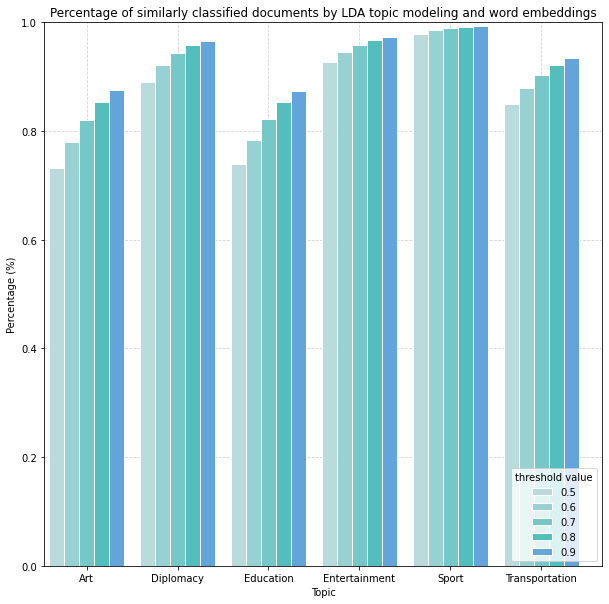

In [137]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10), facecolor="w")
# set width of bars
barWidth = 0.25

r1 =  np.arange(0, len(topic_values[0])+3, 1.50)
# r1 = np.arange(0, len(topic_values[0])+1.5, 1.50)
colors =["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#97d2fb", "#eccbd9", "#eccbd9"]
colors = [ "#badbdb","#98d1d1", "#76c8c8","#54bebe", "#63a4da", "#296ead", "#2a4693"]

for idx, topic in enumerate(new_topic_values):
    plt.bar(r1, topic, color=colors[idx], width=barWidth, edgecolor='white', label=thresholds[idx], zorder=3)
    r1= [x + barWidth for x in r1]

# Add xticks on the middle of the group bars
plt.ylabel('Percentage (%)', fontweight='normal')
plt.xlabel('Topic')
plt.xticks([0.5, 2, 3.5,  5, 6.5, 8], ['Art', 'Diplomacy', 'Education', 'Entertainment', 'Sport', 'Transportation'])
plt.ylim(0, 1)
plt.xlim(-0.2, 9)

# Create legend & Show graphic
plt.title('Percentage of similarly classified documents by LDA topic modeling and word embeddings')
plt.legend(title="threshold value", loc="lower right")
plt.grid(zorder=0, color='lightgray', linestyle='--')
plt.show()

In [ ]:
# LDA

### 5. Aggregate paragraphs Classification into City Pair Classification

#### 5.1 Select right parameters

In [138]:
bottom_lda_threshold = 0.7
minimal_paragraph_length = 5

In [139]:
temp_df = updated_df[(updated_df['city_pair'].isin(updated_df['city_pair'].unique()[:])) & (updated_df['lda_dominant_score'] > bottom_lda_threshold) & (updated_df['merged_POS'].str.len() > minimal_paragraph_length)]

In [140]:
temp_df
# temp_df[temp_df['idxmax'] != 'Education']['same_categorisation'].value_counts(normalize=True)

,paragraph_id,city_pair,paragraph,merged_POS,lda_sport,lda_art,lda_diplomacy,lda_entertainment,lda_transportation,lda_education,lda_dominant,lda_dominant_score,art,diplomacy,education,entertainment,sport,transportation,embedding_dominant,same_categorisation
0,1,berlin_milan,"after his tenure in academia, he continued to ...","[tenure, academia, month, year, travel, incide...",0.000765,0.001501,0.770121,0.001536,0.001327,0.224750,lda_diplomacy,0.770121,1.077087,9.597548,1.932452,0.000000,2.453161,2.040116,diplomacy,True
2,3,berlin_milan,there are plenty of air connections between ye...,"[plenty, air, connection, city, connection, ci...",0.000873,0.001713,0.002005,0.001754,0.991741,0.001914,lda_transportation,0.991741,0.000000,1.592254,0.531098,0.000000,1.199944,11.011679,transportation,True
4,5,berlin_milan,when considering the commuter belts or metropo...,"[commuter, belt, area, datum, population, orde...",0.002721,0.005337,0.094386,0.005463,0.886130,0.005962,lda_transportation,0.886130,0.000000,0.809625,0.446223,0.347665,0.000000,2.849543,transportation,True
5,6,berlin_milan,the eu contains about 40 urban areas with popu...,"[area, population, population, area, megacity,...",0.002721,0.005337,0.094386,0.005463,0.886130,0.005962,lda_transportation,0.886130,0.448596,1.165424,0.000000,0.000000,0.000000,2.124994,transportation,True
7,8,berlin_milan,"in the spring of 1875, lister along with agnes...","[spring, lister, sister, law, niece, group, we...",0.000601,0.040131,0.858321,0.040159,0.001043,0.059745,lda_diplomacy,0.858321,0.000000,2.280080,1.293481,3.699103,3.821776,1.276921,sport,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310822,312681,warsaw_valencia,"as a concert singer, mikolaj had a broad reper...","[concert, singer, repertoire, work, symphony, ...",0.000985,0.193347,0.002260,0.799541,0.001708,0.002158,lda_entertainment,0.799541,1.020590,1.488301,3.178821,6.428997,0.000000,0.460198,entertainment,True
310823,312682,warsaw_valencia,"since 2010, edelmann has intensified his conce...","[concert, activity, guest, performance, recita...",0.001889,0.003704,0.004335,0.982658,0.003276,0.004139,lda_entertainment,0.982658,0.000000,0.760049,0.456211,4.984097,0.000000,0.000000,entertainment,True
310824,312683,warsaw_valencia,"born maria mokrzycka in lviv (now ukraine), sh...","[conservatory, debut, opera, opera, time, bari...",0.000729,0.001430,0.001673,0.993306,0.001264,0.001597,lda_entertainment,0.993306,1.716277,0.773917,2.472730,9.914883,1.060039,1.210814,entertainment,True
310825,312684,warsaw_valencia,ayala was elected a fellow of the american aca...,"[fellow, art, science, member, society, member...",0.001683,0.003300,0.003862,0.003379,0.002918,0.984857,lda_education,0.984857,1.750858,2.044300,6.493432,0.000000,0.000000,0.000000,education,True


In [141]:
grouped_df = temp_df.groupby('city_pair')

In [153]:
nested_list2 = [['city_pair', 'paragraphs', 'lemmatised_paragraph_length', 'same_categorisation_raw', 'same_categorisation_percentage',
                'lda_dominant_category', 'embedding_dominant_category', 'lda_art', 'embedding_art', 'lda_diplomacy',
                'embedding_diplomacy', 'lda_education', 'embedding_education', 'lda_entertainment', 'embedding_entertainment', 
                'lda_sport', 'embedding_sport', 'lda_transportation', 'embedding_transportation']]

In [143]:
topics

['art', 'diplomacy', 'education', 'entertainment', 'sport', 'transportation']

In [150]:
print(list(temp_df['embedding_dominant'].unique()))
list(temp_df['lda_dominant'].unique())

['diplomacy', 'transportation', 'sport', 'education', 'entertainment', 'art']


['lda_diplomacy',
 'lda_transportation',
 'lda_education',
 'lda_entertainment',
 'lda_art',
 'lda_sport']

In [154]:
from IPython.display import display

lda_categories = list(temp_df['lda_dominant'].unique())
embedding_categories = list(temp_df['embedding_dominant'].unique())

for city_pair, sub_df in tqdm(grouped_df):
    paragraph_count = sub_df['paragraph'].count()
    same_categorisation_raw = sub_df['same_categorisation'].sum()
    same_categorisation_percentage = sub_df['same_categorisation'].sum()/sub_df['same_categorisation'].count()
    lemmatised_paragraph_len = sub_df['merged_POS'].str.len().mean()
    
    lda_prediction = sub_df['lda_dominant'].value_counts()
    embedding_prediction = sub_df['embedding_dominant'].value_counts()
        
    lda_dominant_category = lda_prediction.idxmax()
    embedding_dominant_category = embedding_prediction.idxmax()
    
    lda_prediction = lda_prediction.to_dict()
    embedding_prediction = embedding_prediction.to_dict()
    
    if (len(lda_prediction) != len(lda_categories)):
        for category in lda_categories:
            if category not in lda_prediction.keys():
                lda_prediction[category] = 0
                
    if (len(embedding_prediction) != len(embedding_categories)):
        for category in embedding_categories:
            if category not in embedding_prediction.keys():
                embedding_prediction[category] = 0
                
    temp_l2 = [city_pair, paragraph_count, lemmatised_paragraph_len, same_categorisation_raw, same_categorisation_percentage,
                lda_dominant_category, embedding_dominant_category, lda_prediction['lda_art'], embedding_prediction['art'], lda_prediction['lda_diplomacy'],
                embedding_prediction['diplomacy'], lda_prediction['lda_education'], embedding_prediction['education'],
                lda_prediction['lda_entertainment'], embedding_prediction['entertainment'], lda_prediction['lda_sport'],
                embedding_prediction['sport'], lda_prediction['lda_transportation'], embedding_prediction['transportation']]
    if len(nested_list2[0]) != len(temp_l2):
        raise Exception('Not the same size!')
    
    nested_list2.append(temp_l2)

  0%|          | 0/434 [00:00<?, ?it/s]

In [164]:
final_df = pd.DataFrame(nested_list2[1:],columns=nested_list2[0])

final_df.head(2)

,city_pair,paragraphs,lemmatised_paragraph_length,same_categorisation_raw,same_categorisation_percentage,lda_dominant_category,embedding_dominant_category,lda_art,embedding_art,lda_diplomacy,embedding_diplomacy,lda_education,embedding_education,lda_entertainment,embedding_entertainment,lda_sport,embedding_sport,lda_transportation,embedding_transportation
0,athens_birmingham,90,31.355556,85,0.944444,lda_education,education,10,10,3,7,26,24,11,11,25,23,15,15
1,athens_brussels,163,29.288344,148,0.907975,lda_diplomacy,diplomacy,23,22,42,47,21,19,31,29,12,14,34,32


In [168]:
final_df.to_csv('..\..\..\..\..\data\clean\deliverable_435city_pairs_both_methods_with_education_final.csv', index=False)

### Normalise classification (by number of paragraphs)

In [179]:
# Normalize category outcomes
final_df_normalised = final_df
final_df_normalised[list(final_df_normalised.columns)[7:]] = final_df_normalised[list(final_df_normalised.columns)[7:]].div(final_df_normalised['paragraphs'], axis=0) # .count()

final_df_normalised

,city_pair,paragraphs,lemmatised_paragraph_length,same_categorisation_raw,same_categorisation_percentage,lda_dominant_category,embedding_dominant_category,lda_art,embedding_art,lda_diplomacy,embedding_diplomacy,lda_education,embedding_education,lda_entertainment,embedding_entertainment,lda_sport,embedding_sport,lda_transportation,embedding_transportation
0,athens_birmingham,90,31.355556,85,0.944444,lda_education,education,0.001235,0.001235,0.000370,0.000864,0.003210,0.002963,0.001358,0.001358,0.003086,0.002840,0.001852,0.001852
1,athens_brussels,163,29.288344,148,0.907975,lda_diplomacy,diplomacy,0.000866,0.000828,0.001581,0.001769,0.000790,0.000715,0.001167,0.001091,0.000452,0.000527,0.001280,0.001204
2,athens_bucharest,116,34.767241,108,0.931034,lda_diplomacy,diplomacy,0.000520,0.000372,0.003344,0.003567,0.001709,0.001784,0.000669,0.000669,0.000595,0.000595,0.001784,0.001635
3,athens_budapest,152,30.217105,139,0.914474,lda_sport,sport,0.000563,0.000346,0.000822,0.001039,0.000519,0.000519,0.001082,0.000995,0.001904,0.001991,0.001688,0.001688
4,athens_cologne,46,33.391304,43,0.934783,lda_entertainment,entertainment,0.003308,0.004253,0.001418,0.001890,0.003308,0.002363,0.008979,0.008979,0.002363,0.002363,0.002363,0.001890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,warsaw_stockholm,181,31.353591,165,0.911602,lda_diplomacy,diplomacy,0.000702,0.000641,0.001496,0.001648,0.000610,0.000488,0.000824,0.000855,0.000977,0.001068,0.000916,0.000824
430,warsaw_stuttgart,49,33.734694,42,0.857143,lda_entertainment,entertainment,0.003748,0.002499,0.002915,0.003332,0.000416,0.000416,0.009579,0.009163,0.001249,0.002499,0.002499,0.002499
431,warsaw_turin,41,30.439024,38,0.926829,lda_entertainment,entertainment,0.002380,0.001785,0.001785,0.001785,0.004759,0.004759,0.011303,0.011898,0.002380,0.002380,0.001785,0.001785
432,warsaw_valencia,37,38.405405,36,0.972973,lda_entertainment,entertainment,0.000730,0.000730,0.002191,0.002191,0.002922,0.002922,0.010226,0.009496,0.009496,0.009496,0.001461,0.002191


In [178]:
final_df_normalised.to_csv('..\..\..\..\..\data\clean\deliverable_435city_pairs_both_methods_with_education_final_normalised.csv', index=False)

# Extras

#### Show closest words to topic vector

In [14]:
from scipy import spatial
from preprocessing_functions import *

def find_closest_embeddings(embedding, cutoff=25):
    return sorted(embeddings_dict.keys(), key=lambda token: spatial.distance.euclidean(embeddings_dict[token], embedding))

In [15]:
topic = 'art'

words = find_closest_embeddings(embedding=
     mean_vectors_dict[topic]    # embeddings_dict['diplomacy'] # embeddings_dict['fashion']
)[:2000]


In [ ]:
english_words = get_english_words(path='../../../input/english_words_alpha_370k.txt
print(remove_non_existing_words_from_wordlist(words, english_words))